In [149]:
import os
import pandas as pd
import numpy as np
import gzip
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler
import yaml
import pandas as pd
import gzip

In [150]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969'
os.chdir(wd_dir)

In [151]:
sharon_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/Sharon_RNA/samples/all/runs/all/fastq/merge-by-read/trimmed/trimmomatic/mapped/STAR/merged/featureCounts/merged'

# Local Functions

In [152]:
def load_yaml_file(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

def load_counts_data(counts_file):
    with gzip.open(counts_file, 'rt') as f:
        counts_data = pd.read_csv(f, sep='\t')
    return counts_data

def load_geo_data(file_path):
    with gzip.open(file_path, 'rt') as f:
        data = pd.read_csv(f, sep='\t', index_col=0)
    return data

def process_counts_data(counts_data):
    counts_matrix = counts_data.set_index('Geneid')
    sample_columns = counts_matrix.columns[5:]
    counts_matrix = counts_matrix[sample_columns]
    return counts_matrix

def unified_rnaseq_processing(data, is_counts=True):
    if is_counts:
        # For count data (sharon), first convert to CPM
        data = data.apply(lambda x: x / x.sum() * 1e6, axis=0)
    
    # Log2 transform (add small value to avoid log(0))
    data_log2 = np.log2(data + 1)
    
    # Filter low-expression genes
    data_filtered = data_log2[data_log2.mean(axis=1) > 1]
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data_filtered.T).T,
                               index=data_filtered.index,
                               columns=data_filtered.columns)
    
    return scaled_data, data_filtered

def create_distribution_plots(data, title_prefix, save_to_file=False):
    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.title(f"{title_prefix} - Boxplot of Gene Expression")
    plt.xlabel("Samples")
    plt.ylabel("Expression")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_boxplot.png")
        plt.close()
    else:
        plt.show()

    # Density plot
    plt.figure(figsize=(12, 6))
    for column in data.columns:
        sns.kdeplot(data=data[column], label=column)
    plt.title(f"{title_prefix} - Density Plot of Gene Expression")
    plt.xlabel("Expression")
    plt.ylabel("Density")
    plt.tight_layout()
    if save_to_file:
        plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_density.png")
        plt.close()
    else:
        plt.show()

# GSE98969 data


## Load GSE98969 data

In [153]:
# Load DAM data from GSE98969 and aggregate to bulk-like samples
dam_files = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith('.txt.gz') and f.startswith('GSM')]
dam_data_list = []
for file in dam_files:
    sample_data = load_geo_data(file)
    sample_name = os.path.basename(file).split('_')[0]  # Use GSM ID as sample name
    # Sum expression across all cells to create a bulk-like sample
    bulk_like_sample = sample_data.sum(axis=1)
    dam_data_list.append(pd.DataFrame(bulk_like_sample, columns=[sample_name]))

dam_data = pd.concat(dam_data_list, axis=1)

In [154]:
# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_data.csv")
dam_data.to_csv(output_file)
print(f"Saved dam_data to {output_file}")

Saved dam_data to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_data.csv


In [155]:
dam_data.head()

,GSM2629433,GSM2629365,GSM2629414,GSM2629390,GSM2629354,GSM2629393,GSM2629427,GSM2629341,GSM2629421,GSM2629368,...,GSM2629372,GSM2629377,GSM2629348,GSM2629352,GSM2629398,GSM2629416,GSM2629438,GSM2629410,GSM2629397,GSM2629344
0610005C13Rik,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,2,1,0
0610007C21Rik,53,40,28,70,46,65,37,61,33,85,...,110,19,79,61,50,39,62,38,39,92
0610007L01Rik,23,36,14,29,23,26,42,18,20,22,...,28,22,27,20,35,17,25,19,19,27
0610007P08Rik,0,0,5,8,3,11,5,12,1,5,...,9,4,12,5,3,3,0,3,7,14
0610007P14Rik,9,14,6,4,8,17,16,2,13,14,...,24,22,15,11,6,6,6,10,15,22


## Filter GSE98969 data

In [156]:
# Process DAM data
# The DAM data, being derived from single-cell RNA-seq, is likely already normalized in some way (possibly as TPM or RPKM)
dam_processed, dam_filtered = unified_rnaseq_processing(dam_data, is_counts=False)

In [157]:
# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_processed.csv")
dam_processed.to_csv(output_file)
print(f"Saved dam_processed to {output_file}")

# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_filtered.csv")
dam_filtered.to_csv(output_file)
print(f"Saved dam_filtered to {output_file}")

Saved dam_processed to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_processed.csv
Saved dam_filtered to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_filtered.csv


# Sharon data

## Load Sharon data

In [158]:
sharon_counts_file = os.path.join(sharon_dir, "all.counts.gz")
sharon_counts_data = load_counts_data(sharon_counts_file)

In [159]:
sharon_counts_data.head()

,Geneid,Chr,Start,End,Strand,Length,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
0,4933401J01Rik,chr1,3073253,3074322,+,1070,0,0,18,0,...,2,6,4,7,0,0,26,16,0,5
1,Gm26206,chr1,3102016,3102125,+,110,0,0,0,0,...,0,0,0,2,0,0,0,1,0,0
2,Xkr4,chr1;chr1;chr1,3214482;3421702;3670552,3216968;3421901;3671498,-;-;-,3634,12,102,176,50,...,8,13,22,16,6,177,34,42,4,95
3,Gm18956,chr1,3252757,3253236,+,480,0,0,0,0,...,2,0,0,1,0,0,2,1,0,0
4,Gm37180,chr1,3365731,3368549,-,2819,7,4,51,2,...,28,32,2,21,14,0,16,17,12,0


In [160]:
sharon_bulk_counts = process_counts_data(sharon_counts_data)

In [161]:
# Display information about the matrix
print("\nMatrix shape:", sharon_bulk_counts.shape)
print("Number of genes:", sharon_bulk_counts.shape[0])
print("Number of samples:", sharon_bulk_counts.shape[1])


Matrix shape: (55376, 30)
Number of genes: 55376
Number of samples: 30


In [162]:
sharon_bulk_counts.head()

,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,REMI_m_ADW5_2,REMI_a_AGW5_3,REMI_a_AG_1,REMI_a_AGW_2,REMI_a_AD_1,REMI_a_AGW5_2,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
Geneid,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,0,0,18,0,0,0,6,0,0,4,...,2,6,4,7,0,0,26,16,0,5
Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,1,0,0
Xkr4,12,102,176,50,14,175,10,91,94,100,...,8,13,22,16,6,177,34,42,4,95
Gm18956,0,0,0,0,0,0,0,2,0,0,...,2,0,0,1,0,0,2,1,0,0
Gm37180,7,4,51,2,14,0,10,2,0,5,...,28,32,2,21,14,0,16,17,12,0


In [163]:
sharon_processed, sharon_filtered = unified_rnaseq_processing(sharon_bulk_counts, is_counts=True)

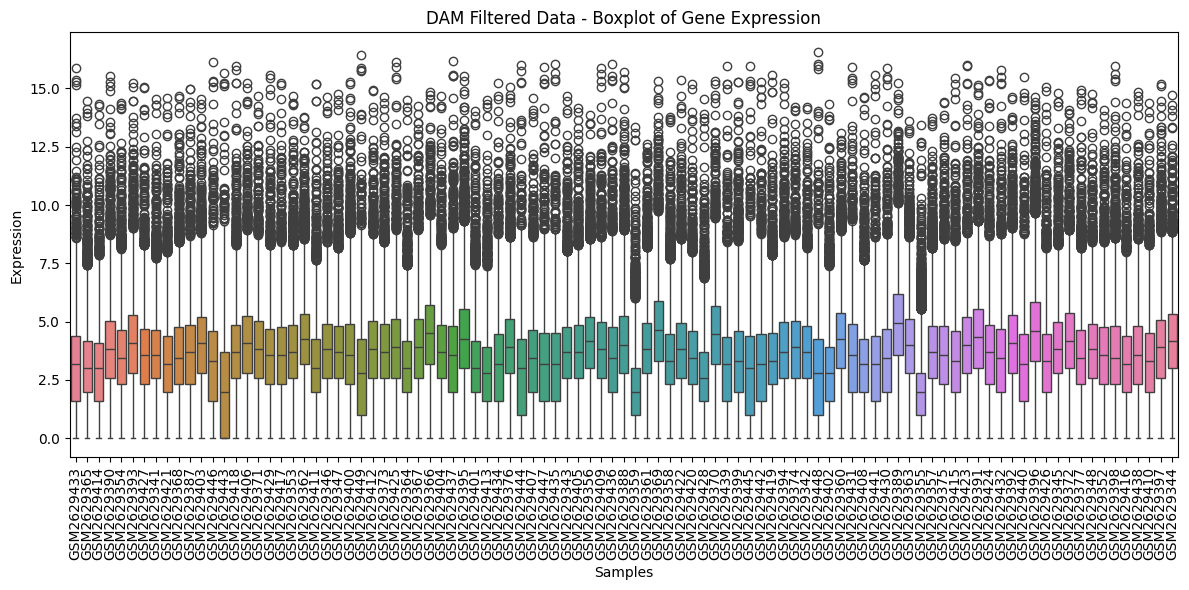

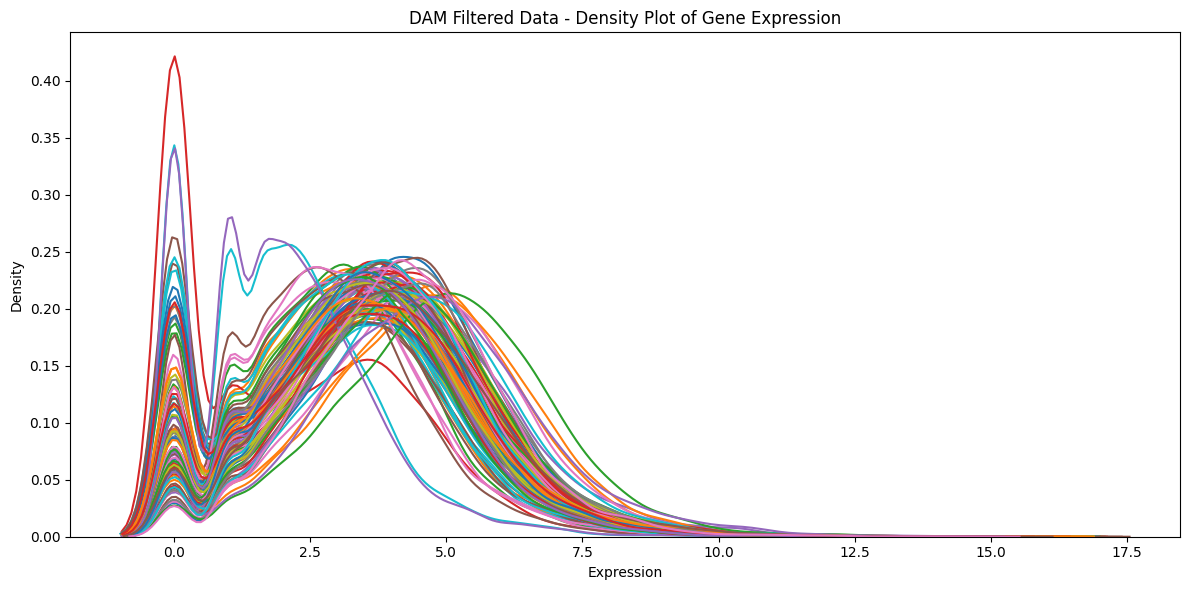

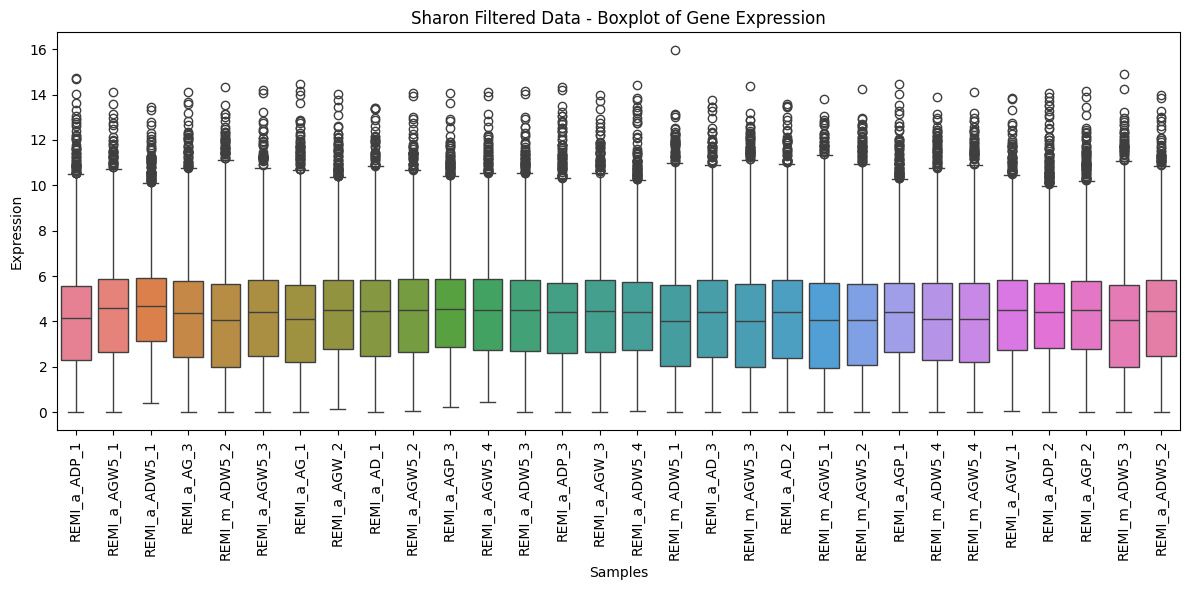

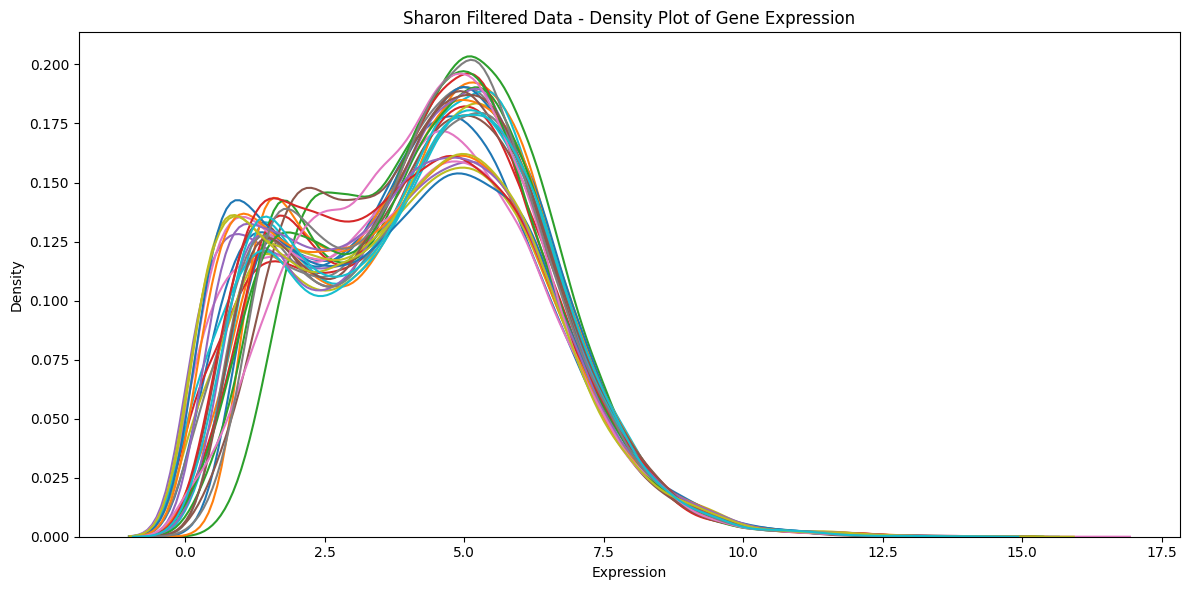

In [164]:
create_distribution_plots(dam_filtered, "DAM Filtered Data")
create_distribution_plots(sharon_filtered, "Sharon Filtered Data")

# Similarity

In [165]:
# Find common genes and subset data
common_genes = list(set(sharon_filtered.index) & set(dam_filtered.index))
sharon_common = sharon_filtered.loc[common_genes]
dam_common = dam_filtered.loc[common_genes]

In [166]:
dam_common.head()

,GSM2629433,GSM2629365,GSM2629414,GSM2629390,GSM2629354,GSM2629393,GSM2629427,GSM2629341,GSM2629421,GSM2629368,...,GSM2629372,GSM2629377,GSM2629348,GSM2629352,GSM2629398,GSM2629416,GSM2629438,GSM2629410,GSM2629397,GSM2629344
Ip6k1,3.700440,4.643856,4.247928,5.426265,5.357552,5.459432,4.807355,4.906891,4.807355,4.169925,...,5.807355,5.000000,5.554589,4.700440,4.700440,4.807355,4.807355,4.584963,4.523562,6.044394
Pycrl,4.087463,3.169925,2.584963,4.087463,2.807355,2.584963,3.000000,1.584963,3.584963,2.807355,...,4.000000,3.584963,3.169925,2.000000,1.584963,1.584963,3.321928,2.321928,4.000000,3.321928
Nup62,4.000000,3.321928,4.169925,2.584963,3.584963,4.754888,1.000000,3.459432,3.459432,4.807355,...,3.321928,3.906891,3.807355,4.459432,3.000000,3.700440,3.000000,3.169925,3.000000,4.392317
Tulp3,1.000000,1.584963,0.000000,3.169925,2.000000,2.321928,0.000000,1.584963,1.000000,1.584963,...,2.584963,0.000000,2.321928,1.000000,3.000000,1.584963,1.584963,1.000000,2.584963,2.321928
Tmem97,1.584963,2.321928,1.584963,3.584963,1.000000,3.321928,3.000000,3.169925,2.807355,3.906891,...,2.000000,3.000000,3.321928,2.584963,2.321928,2.321928,1.000000,2.321928,2.321928,3.169925


In [167]:
sharon_common.head()

,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,REMI_m_ADW5_2,REMI_a_AGW5_3,REMI_a_AG_1,REMI_a_AGW_2,REMI_a_AD_1,REMI_a_AGW5_2,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
Geneid,,,,,,,,,,,,,,,,,,,,,
Ip6k1,6.687292,7.755527,7.449202,7.961081,6.871920,7.596234,7.772425,7.209020,7.716624,7.651426,...,7.208933,6.818306,7.311476,7.143128,6.897077,7.423372,7.477230,7.352590,6.747715,7.682310
Pycrl,5.736436,5.188019,4.625356,5.608333,3.853634,4.755054,5.870590,5.099974,5.072131,5.001862,...,3.570723,3.973167,5.623900,3.334077,3.763011,4.840894,5.143744,4.942071,3.859899,5.047573
Nup62,4.302901,4.326967,4.658999,4.447706,4.739429,4.324578,4.322164,4.605235,4.209189,4.310752,...,4.574091,4.807893,4.697245,4.835415,4.804912,4.364611,4.152664,4.427448,4.886299,4.307399
Tulp3,5.068316,6.281679,6.104917,6.330581,3.789651,5.886743,5.620540,5.737921,6.600854,6.138095,...,3.822120,4.011556,5.544295,4.499860,3.937947,5.858374,6.305133,5.725987,3.349896,6.417428
Tmem97,6.232454,4.599619,4.362989,5.446854,3.732455,4.535218,5.925305,4.757825,4.783016,4.513905,...,2.942065,3.867831,4.567353,3.251720,3.706108,4.615926,5.695852,5.009476,3.999073,4.756400


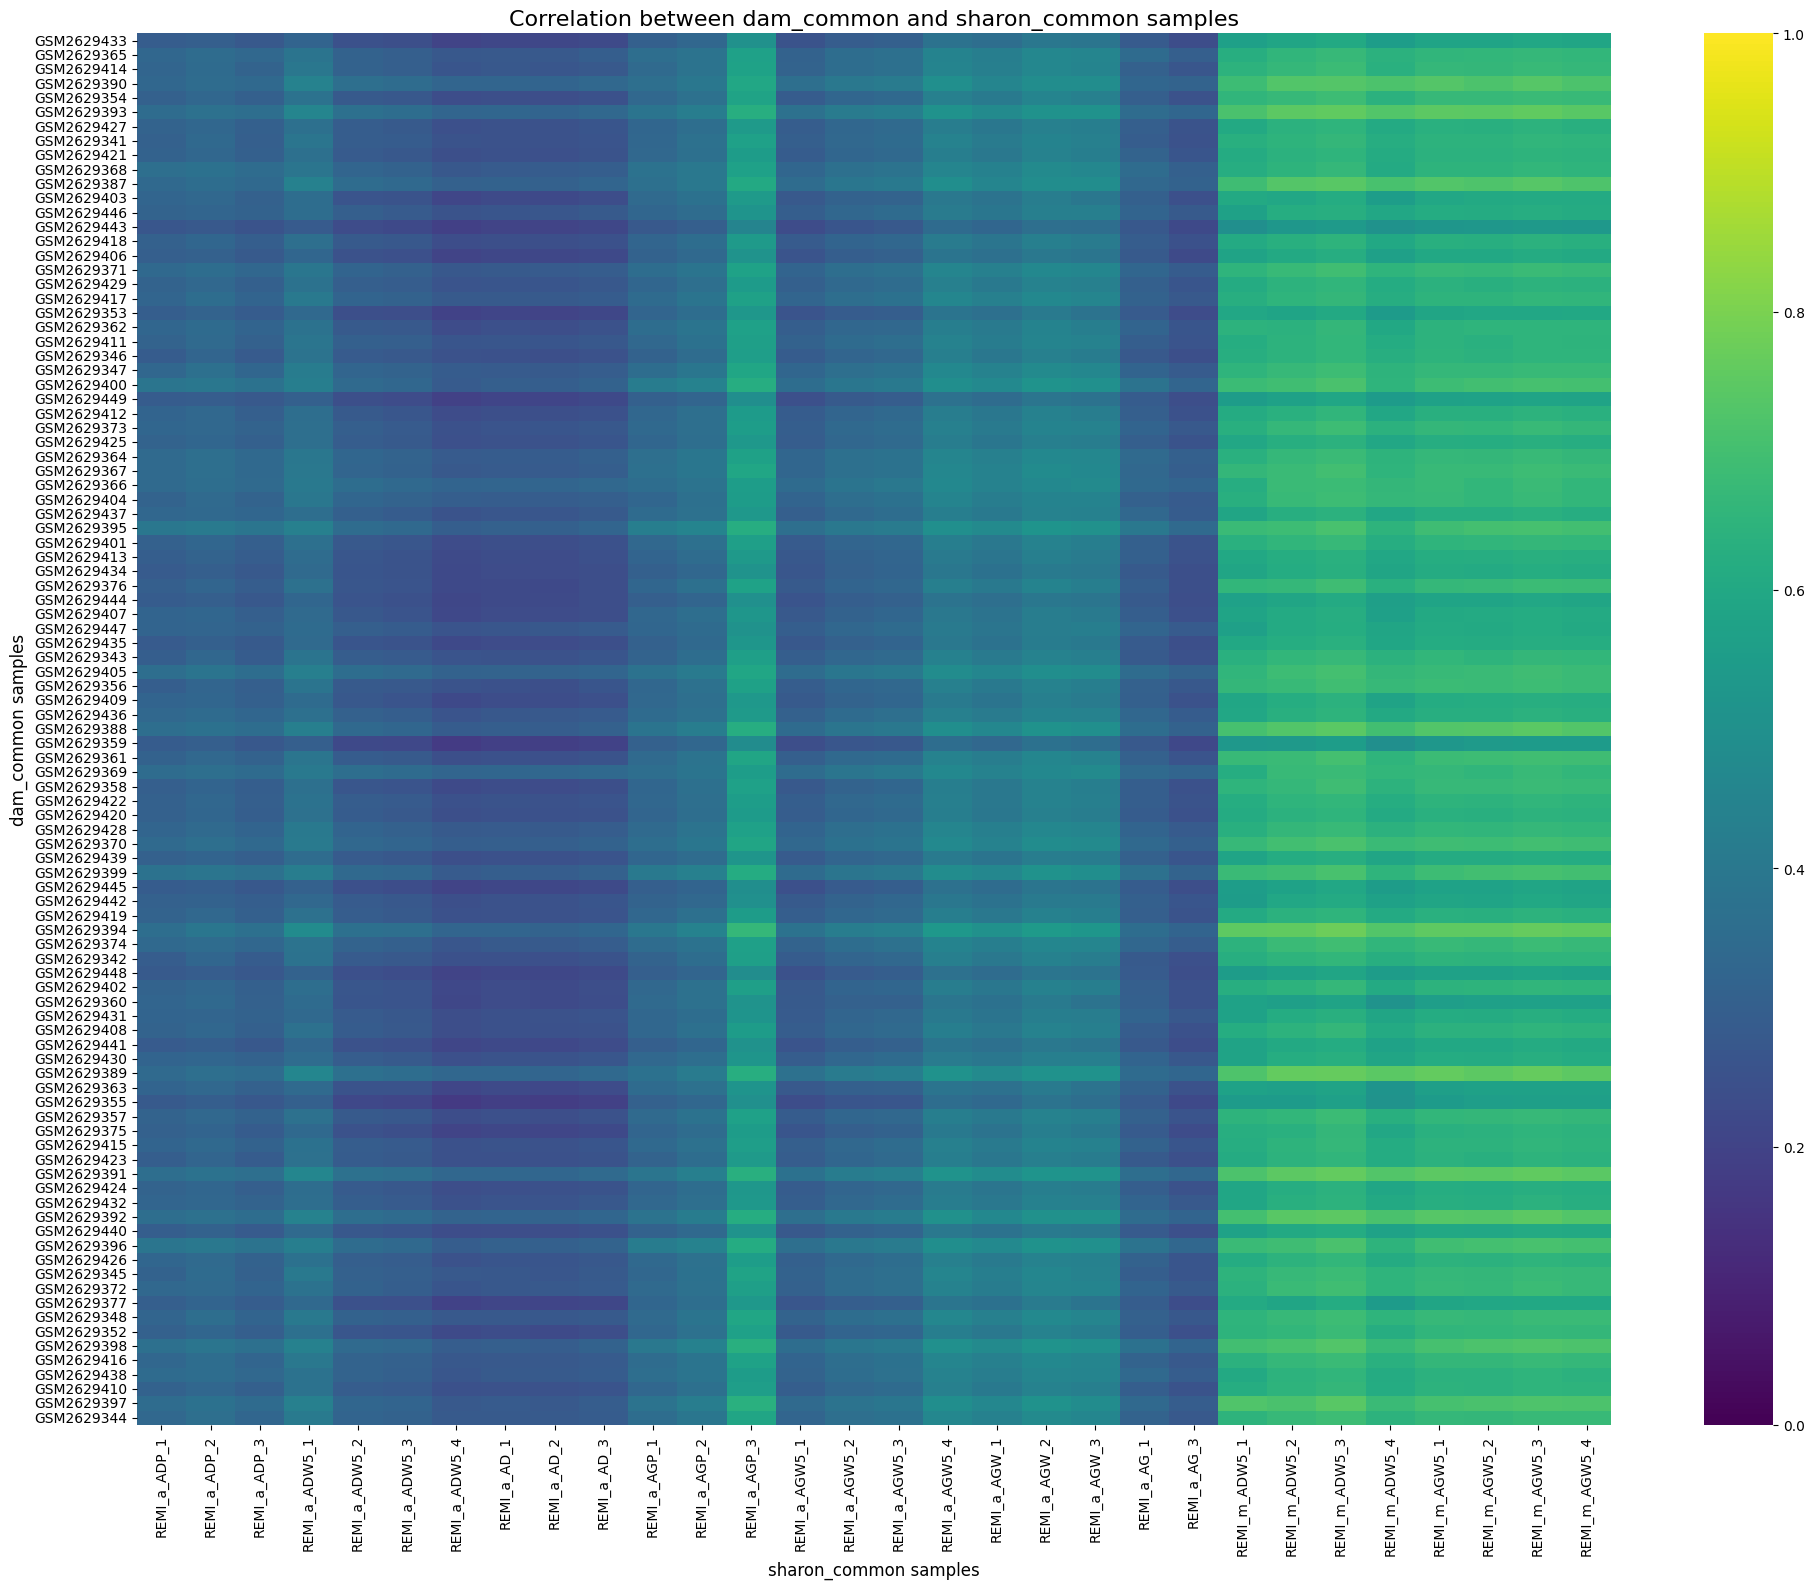

In [168]:
# Convert data to numeric, replacing any non-numeric values with NaN
dam_common = dam_common.apply(pd.to_numeric, errors='coerce')
sharon_common = sharon_common.apply(pd.to_numeric, errors='coerce')

# Sort the columns of sharon_common alphabetically
sharon_common = sharon_common.sort_index(axis=1)

# Calculate correlation matrix
correlation_matrix = pd.DataFrame(index=dam_common.columns, columns=sharon_common.columns)

for dam_col in dam_common.columns:
    for sharon_col in sharon_common.columns:
        dam_data = dam_common[dam_col].dropna()
        sharon_data = sharon_common[sharon_col].dropna()
        
        if len(dam_data) > 1 and len(sharon_data) > 1:
            correlation = np.corrcoef(dam_data, sharon_data)[0, 1]
            correlation_matrix.loc[dam_col, sharon_col] = correlation
        else:
            correlation_matrix.loc[dam_col, sharon_col] = np.nan

# Replace any remaining non-numeric values with NaN
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix, cmap='viridis', center=0.5, vmin=0, vmax=1, 
            xticklabels=True, yticklabels=True)

plt.title('Correlation between dam_common and sharon_common samples', fontsize=16)
plt.xlabel('sharon_common samples', fontsize=12)
plt.ylabel('dam_common samples', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()